In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error,make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import shap
from plot_functions import *

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
plt.rcParams["figure.dpi"] = 500

In [37]:
irrig_df = pd.read_csv("Data/irrig_model_data.csv").drop("Unnamed: 0", axis =1)
irrig_df


,Reported_Irrigation,Year,FieldID,MinTemp_mean,MaxTemp_mean,GDD,NDVI,NDVI_Aug,ET_sum,vpd,Precip_sum,ReferenceET_sum,Tmp_excede33,Percent_Slope,Precip_deficit
0,300.984585,2016,NB1,6.106788,22.029015,1644.890021,0.651859,0.603531,676.170587,1.781269,544.150002,1139.259996,33,5.472,132.020586
1,297.575357,2017,NB1,5.822711,21.877106,1614.254973,0.660628,0.823997,648.051550,1.951652,535.800001,1148.359997,33,5.472,112.251549
2,369.860074,2018,NB1,4.975202,20.631099,1644.100009,0.714815,0.856244,696.440038,1.620673,443.960002,1130.510002,29,5.472,252.480036
3,342.563728,2020,NB1,5.105658,21.794927,1624.754994,0.587987,0.759675,656.890253,1.925848,331.310000,1218.569996,43,5.472,325.580253
4,286.767030,2021,NB1,5.365971,21.024176,1718.870071,0.660427,0.769854,630.049208,1.791752,438.000001,1166.679999,43,5.472,192.049207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,288.890049,2015,NW2,5.889016,22.367288,1700.526132,0.724703,0.892537,726.855923,1.646104,489.789186,1165.082234,44,4.102,237.066737
74,279.738151,2015,NW3,5.895191,22.370999,1701.755233,0.822295,0.879452,808.127990,1.646104,487.784813,1164.180538,44,3.796,320.343176
75,331.420370,2015,NW4,5.889016,22.367288,1700.526132,0.702208,0.872027,747.244986,1.652755,489.789186,1165.082234,44,3.941,257.455799
76,342.272578,2015,NW5,5.889016,22.367288,1700.526132,0.652330,0.863285,691.859398,1.652755,489.789186,1165.082234,44,4.025,202.070211


In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import xgboost as xgb
import numpy as np

# # 1. Select only key features
selected_features = ['GDD', "NDVI", 'Precip_sum',
                  'ReferenceET_sum', 'Percent_Slope', 'Precip_deficit', "vpd"]


X_xgb = irrig_df[selected_features]
Y_xgb = irrig_df["Reported_Irrigation"]

# # full selection
# X_xgb = irrig_df.iloc[:,3:]
# Y_xgb = irrig_df["Reported_Irrigation"]

# 2. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_xgb, Y_xgb, test_size=0.2, random_state=26)

# 3. Define scoring metric and model
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
xgb_regressor = xgb.XGBRegressor()


param_grid = {'colsample_bytree': [0.9],
              'subsample': [0.7],
            'learning_rate': [0.1], 
            'max_depth': [2],
            'n_estimators': [50], 
              'gamma': [0.6], 
            'reg_alpha': [0.4]
            
         }

    

# param_grid = {
#     'n_estimators': [80,100, 50],
#     'max_depth': [5],
#     'learning_rate': [0.1, 0.2],
#     'subsample': [ .7,.9,.8],
#     'colsample_bytree': [ .7,.8,.9],
#     'gamma': [.2, .3, .5, ],
#     "reg_alpha": [.3,.5,.6, .7]
# }

# 5. Grid search
grid_search = GridSearchCV(estimator=xgb_regressor,
                           param_grid=param_grid,
                           scoring=mae_scorer,
                           cv=5,
                           n_jobs=8)
grid_search.fit(X_train, y_train)

# 6. Train best model
best_params_xgb = grid_search.best_params_
print(f'Best Parameters for XGBoost: {best_params_xgb}')

best_xgb_model = xgb.XGBRegressor(**best_params_xgb)
best_xgb_model.fit(X_train, y_train)

# 7. Predictions
y_pred_train = best_xgb_model.predict(X_train)
y_pred_test = best_xgb_model.predict(X_test)

# 8. Evaluation
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"\n--- Training Performance ---")
print(f"MAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}, R²: {r2_train:.4f}")

print(f"\n--- Test Performance ---")
print(f"MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")


Best Parameters for XGBoost: {'colsample_bytree': 0.9, 'gamma': 0.6, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'reg_alpha': 0.4, 'subsample': 0.7}

--- Training Performance ---
MAE: 27.0175, RMSE: 31.9186, R²: 0.8486

--- Test Performance ---
MAE: 34.9221, RMSE: 40.4029, R²: 0.7646


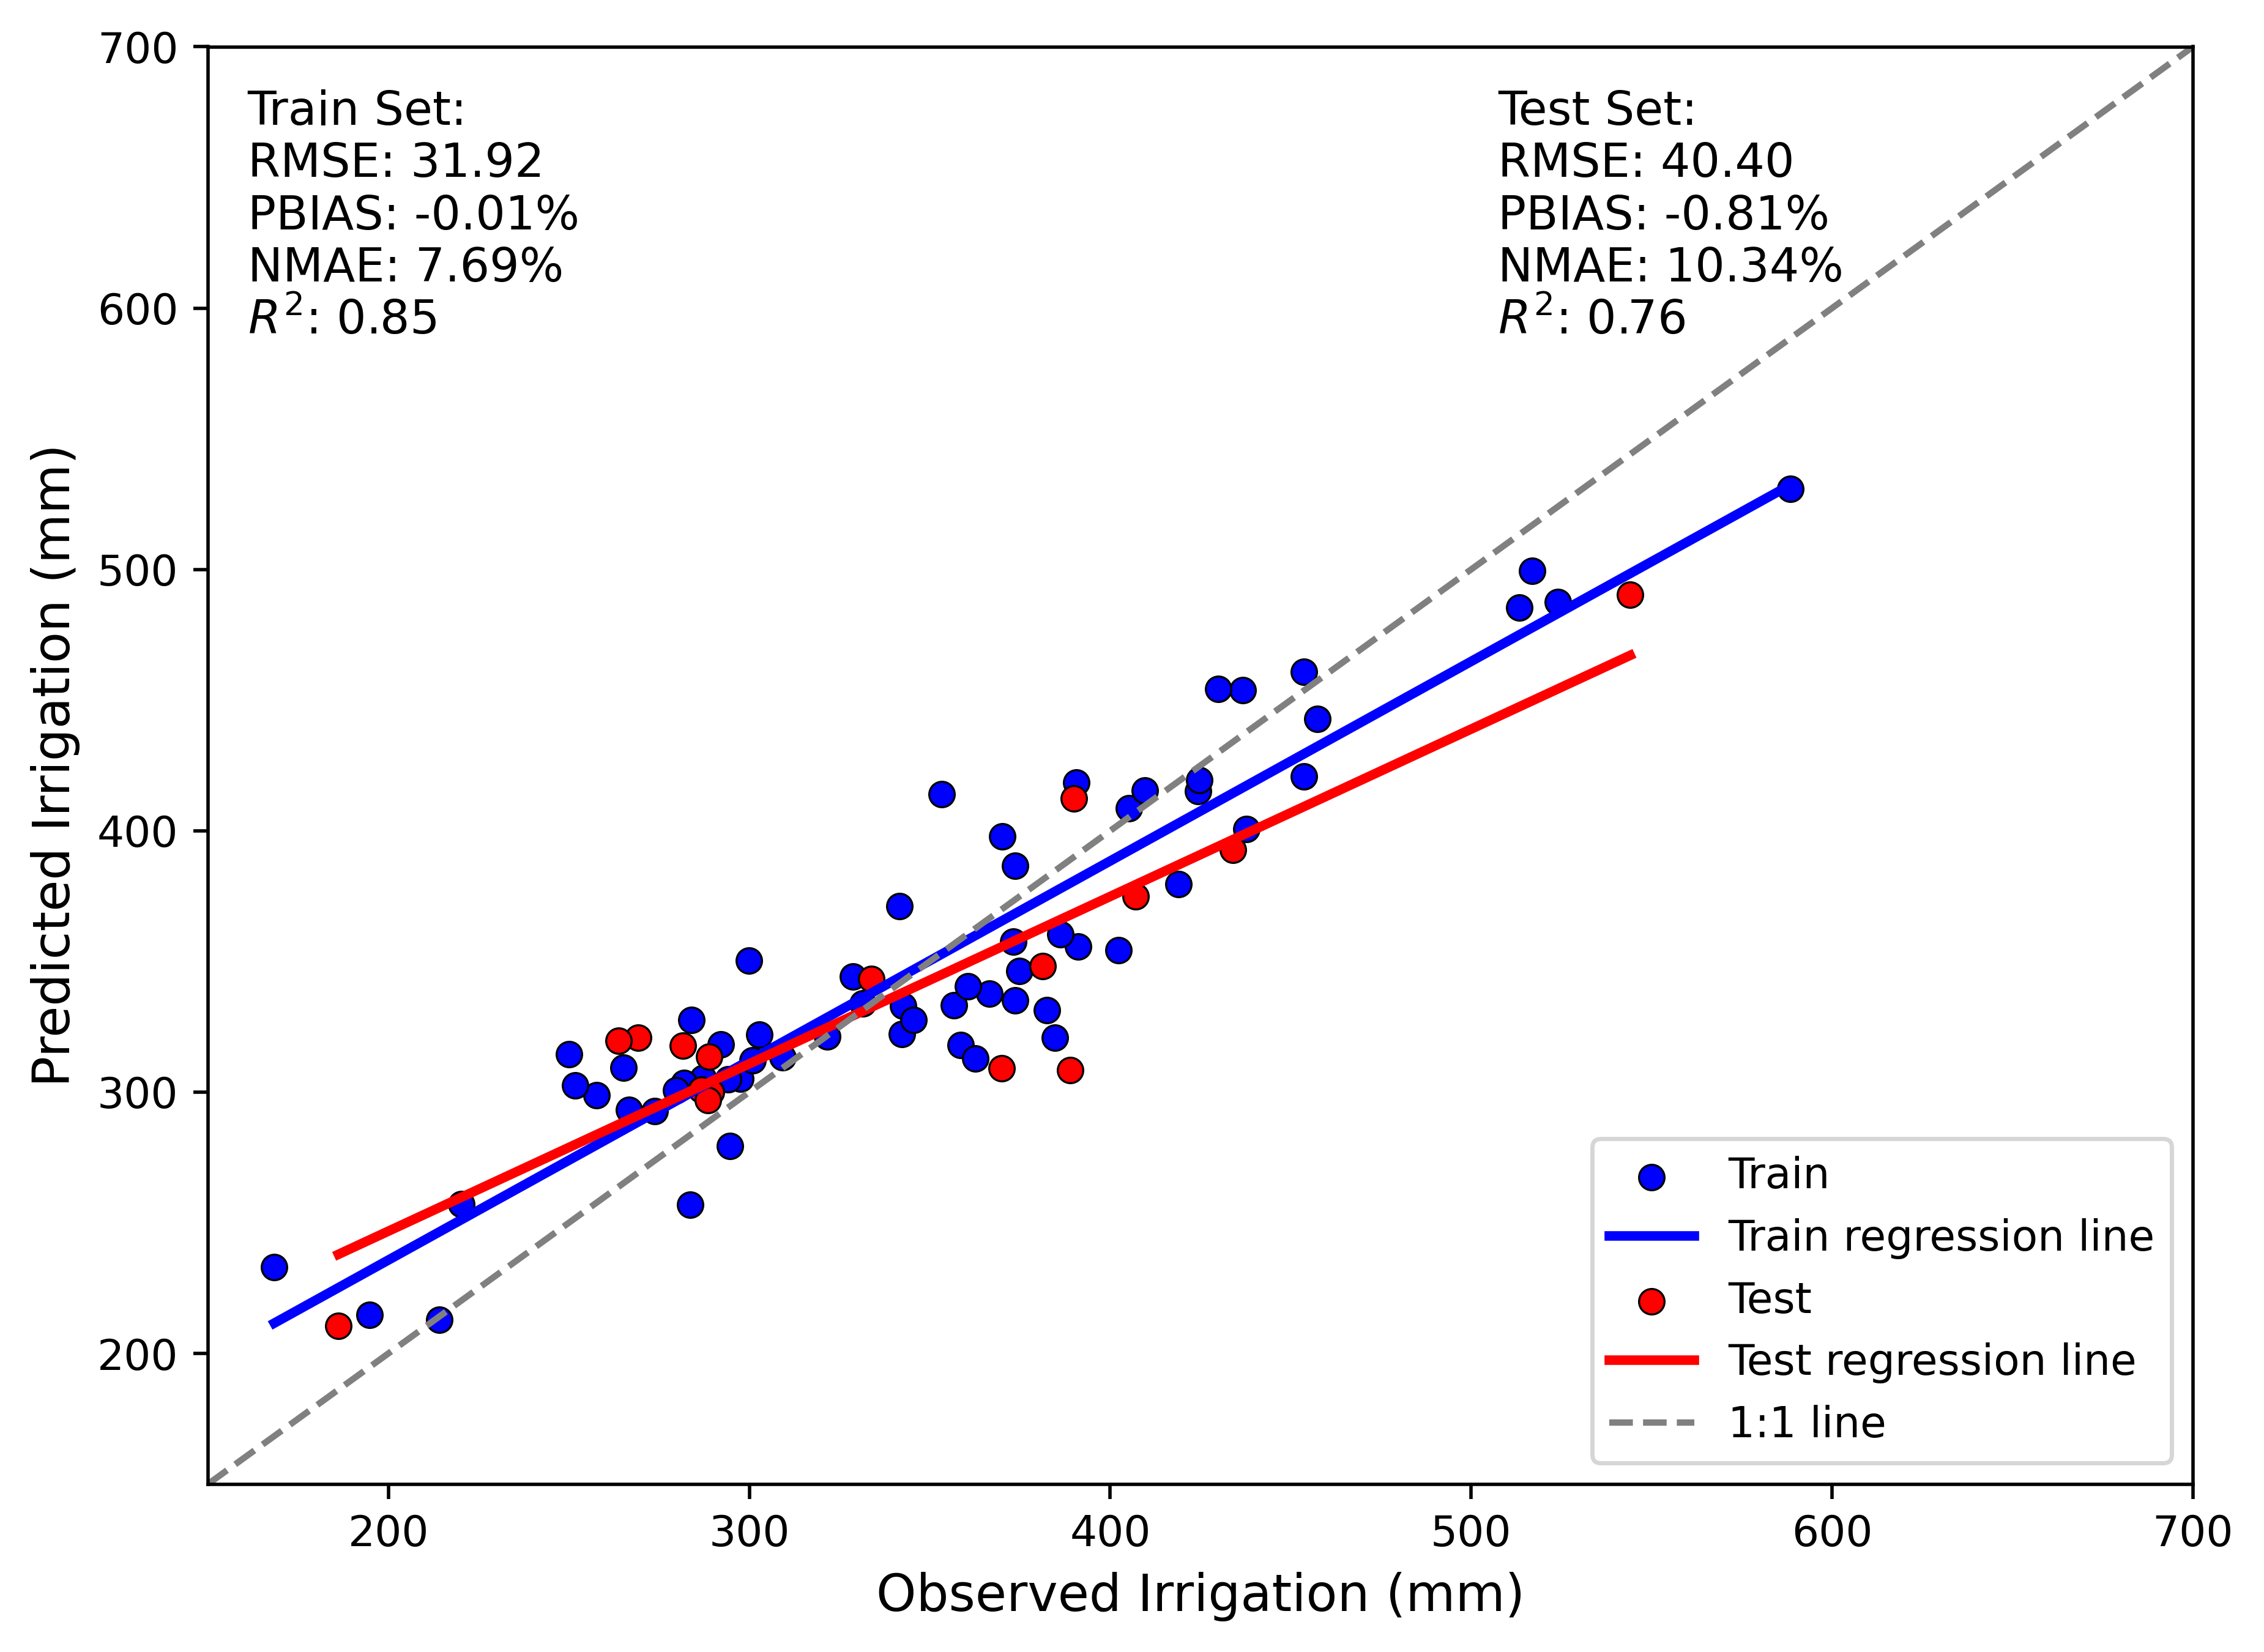

In [20]:
evaluate_model(
    y_train, y_pred_train , 
    y_test, y_pred_test, 
    xlabel='Observed Irrigation', ylabel='Predicted Irrigation', units='mm',
    xlim = (150,700), ylim =(150,700) 
    
)

## 5_CV_testing

In [43]:
X_xgb = irrig_df[selected_features]
Y_xgb = irrig_df["Reported_Irrigation"]
results_df, metrics_df = run_xgb_kfold(X_xgb, Y_xgb, df =irrig_df )
cv5results = results_df
cv5results

,Fold,Set,Actual,Predicted,FieldID,Year
0,1,Train,300.984585,303.104248,NB1,2016
1,1,Train,297.575357,298.761658,NB1,2017
2,1,Train,369.860074,349.747955,NB1,2018
3,1,Train,342.563728,326.676422,NB1,2020
4,1,Train,453.614809,447.995636,NB1,2022
...,...,...,...,...,...,...
385,5,Test,373.126000,389.763367,WC21,2016
386,5,Test,220.218000,350.436798,WC23,2019
387,5,Test,544.068000,502.924988,WC8,2020
388,5,Test,388.874000,333.410675,WC9,2019


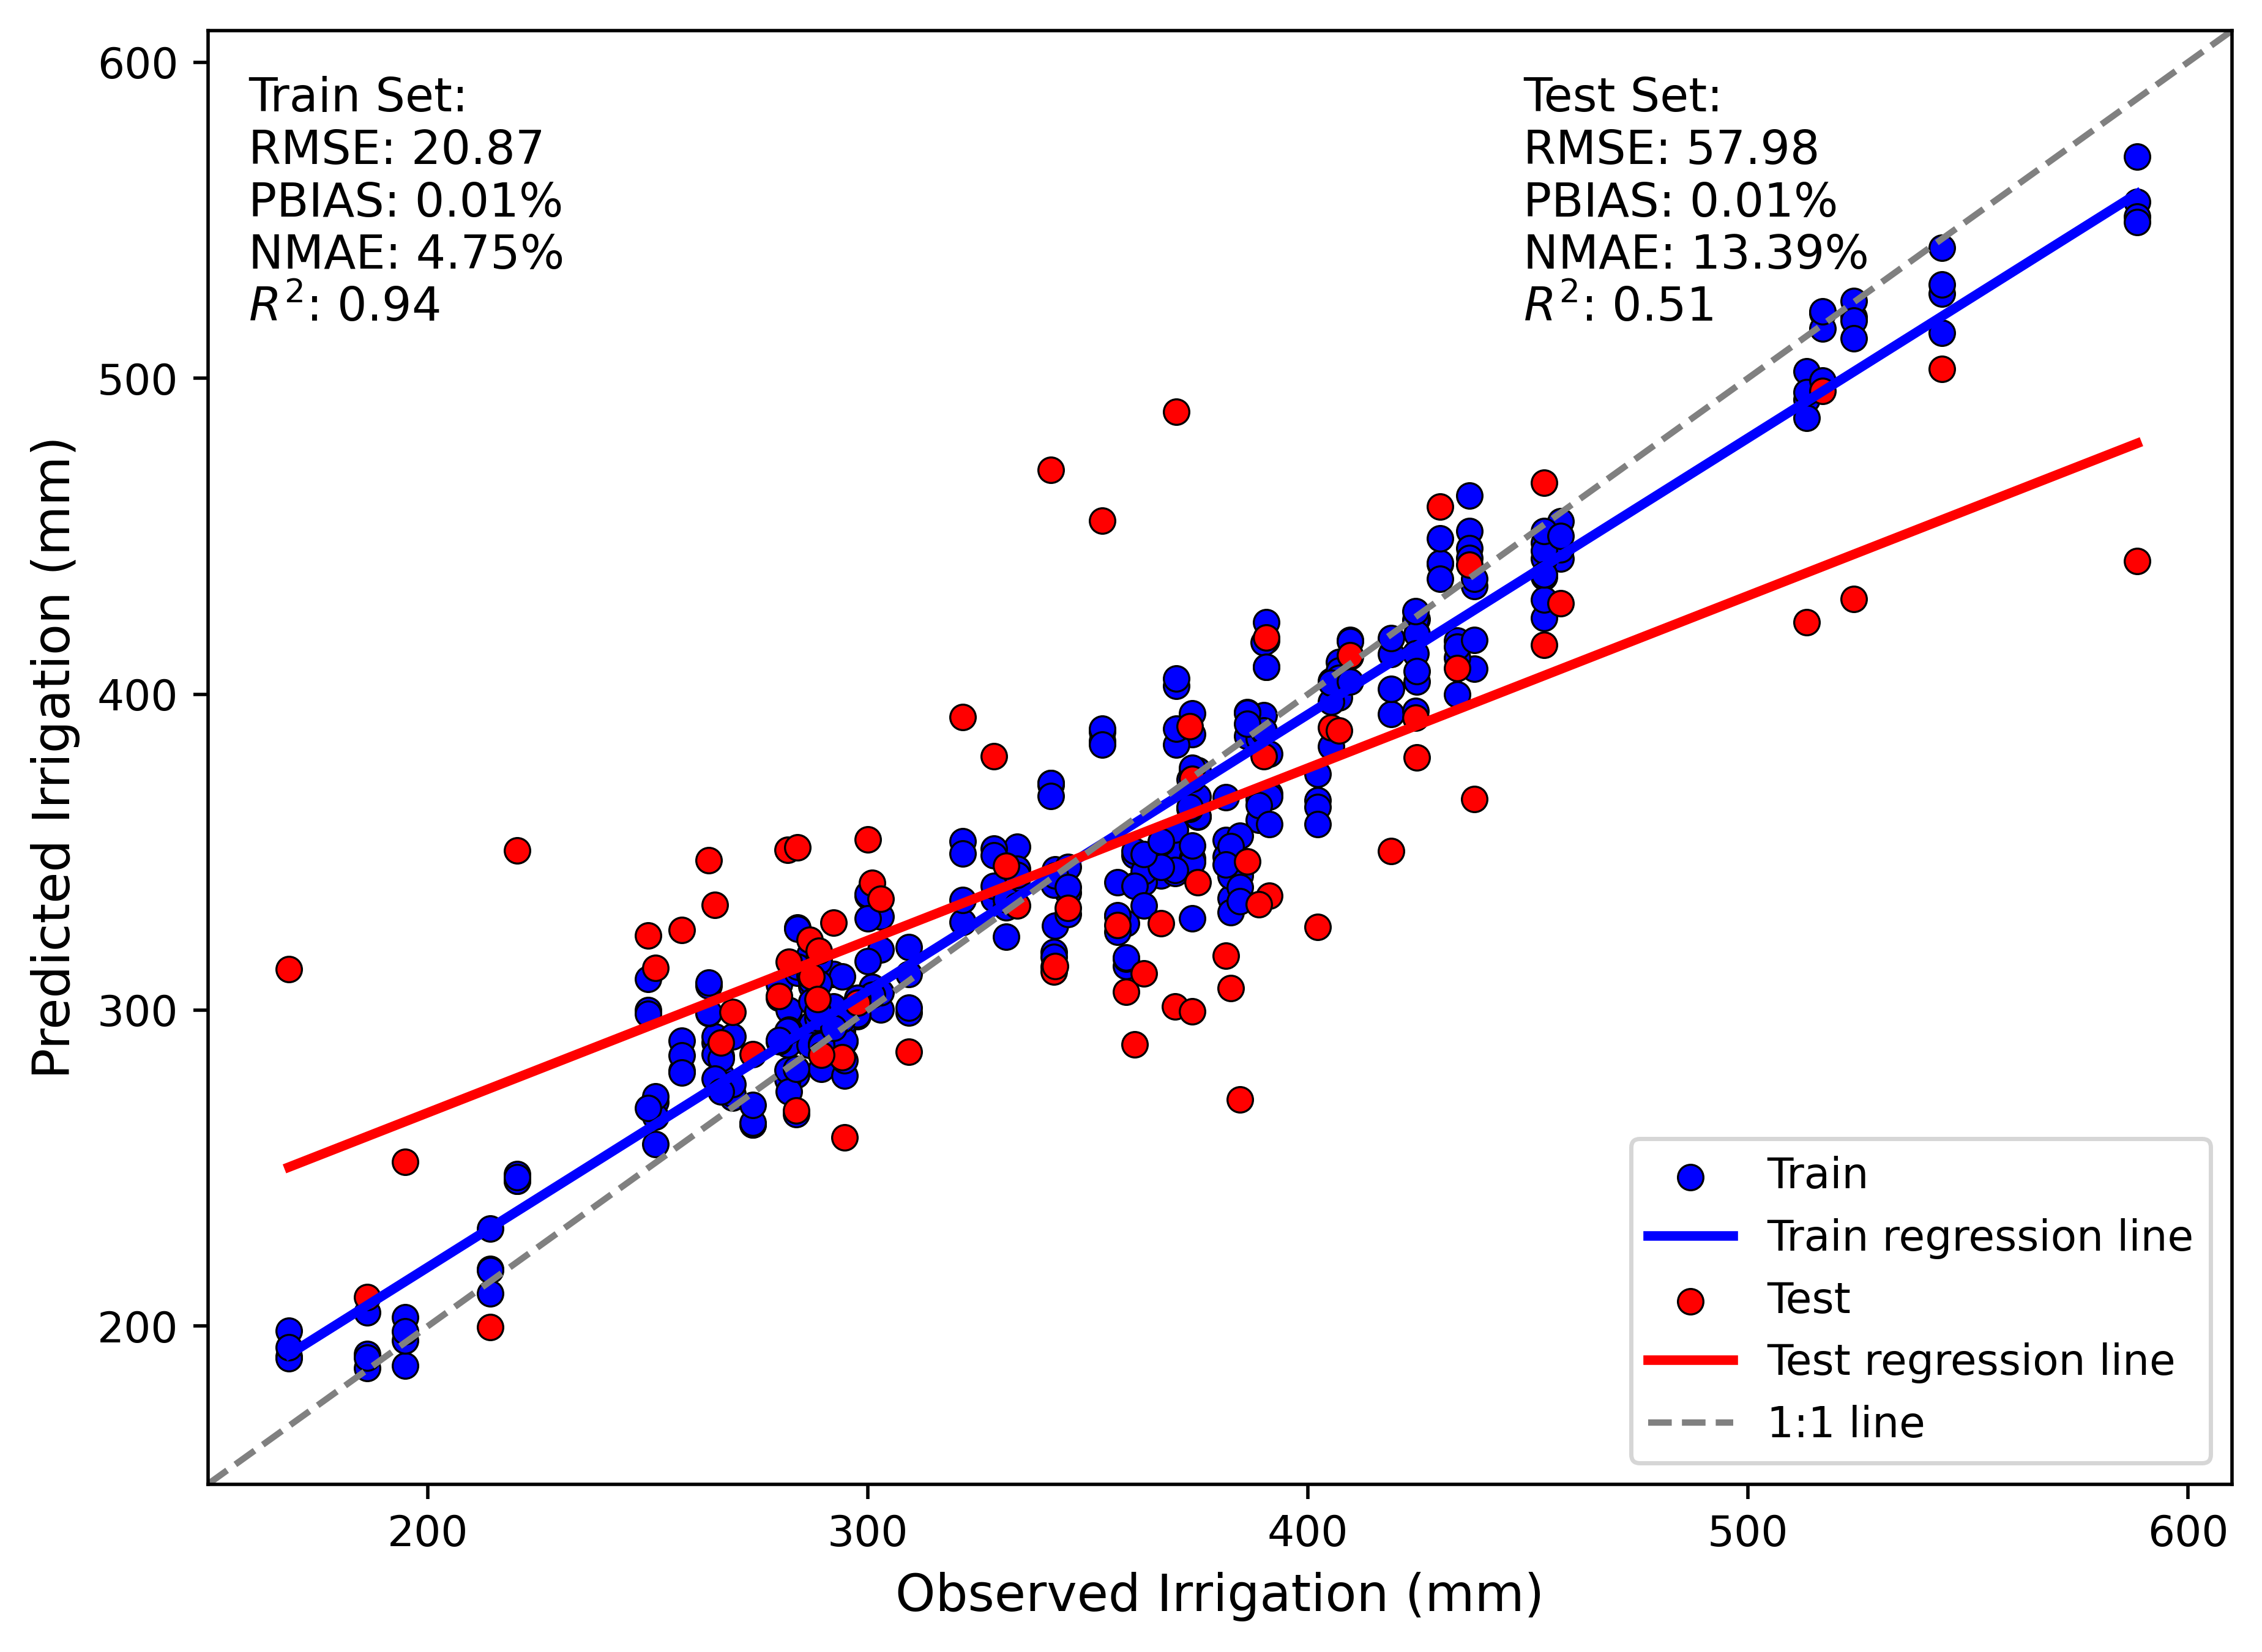

In [44]:
evaluate_model(
    y_train=results_df.loc[results_df["Set"] == "Train", "Actual"],
    y_pred_train=results_df.loc[results_df["Set"] == "Train", "Predicted"],
    y_test = results_df.loc[results_df["Set"] == "Test", "Actual"],
    y_pred_test = results_df.loc[results_df["Set"] == "Test", "Predicted"],
    units='mm',
    text = "Test Set",
    label = "",
#     hue =results_df["Fold"],
    xlabel = "Observed Irrigation", ylabel = "Predicted Irrigation",
    p= .50,
    legend_outside=False,
    xlim = (150, 610), ylim = (150, 610)
    
)


## Holdout tests

In [56]:
train_results, test_results, holdout_results = evaluate_xgboost_holdout(
    df=irrig_df,
    group_col="Year",
    target_col="Reported_Irrigation",
    filter_features=True,
    selected_features=selected_features,
    
param_grid = {'colsample_bytree': [0.9],
              'subsample': [0.7],
            'learning_rate': [0.1], 
            'max_depth': [2],
            'n_estimators': [50], 
              'gamma': [0.6], 
            'reg_alpha': [0.4]
            
         }    
)
irr_hld_yr = holdout_results
train_results



=== Holdout Year: 2016 (12 samples) ===
Holdout MAE: 36.2129
Holdout PBIAS: -4.01%
Holdout R2: 0.45

=== Holdout Year: 2017 (7 samples) ===
Holdout MAE: 39.3137
Holdout PBIAS: 3.95%
Holdout R2: 0.32

=== Holdout Year: 2018 (10 samples) ===
Holdout MAE: 44.5569
Holdout PBIAS: -7.21%
Holdout R2: 0.33

=== Holdout Year: 2020 (15 samples) ===
Holdout MAE: 70.2078
Holdout PBIAS: 7.96%
Holdout R2: 0.25

=== Holdout Year: 2021 (7 samples) ===
Holdout MAE: 34.9997
Holdout PBIAS: 2.21%
Holdout R2: 0.79

=== Holdout Year: 2022 (9 samples) ===
Holdout MAE: 60.2966
Holdout PBIAS: 5.11%
Holdout R2: 0.63

=== Holdout Year: 2019 (12 samples) ===
Holdout MAE: 48.4449
Holdout PBIAS: 0.51%
Holdout R2: -0.21

=== Holdout Year: 2015 (6 samples) ===
Holdout MAE: 39.1502
Holdout PBIAS: 6.90%
Holdout R2: -0.56


,Actual,Predicted,Year
0,297.575357,304.004547,2016
1,369.860074,345.253998,2016
2,342.563728,339.789124,2016
3,286.767030,304.999603,2016
4,453.614809,443.946747,2016
...,...,...,...
541,370.078000,400.839600,2015
542,294.640000,280.769348,2015
543,424.434000,399.242493,2015
544,544.068000,512.333679,2015


In [57]:
train_results, test_results, holdout_results = evaluate_xgboost_holdout(
    df=irrig_df,
    group_col="FieldID",
    target_col="Reported_Irrigation",
    filter_features=True,
    selected_features=selected_features,
    
param_grid = {'colsample_bytree': [0.9],
              'subsample': [0.7],
            'learning_rate': [0.1], 
            'max_depth': [2],
            'n_estimators': [50], 
              'gamma': [0.6], 
            'reg_alpha': [0.4]
            
         }
)

irr_hld_fid = holdout_results




=== Holdout FieldID: NB1 (7 samples) ===
Holdout MAE: 33.4551
Holdout PBIAS: -3.60%
Holdout R2: 0.48

=== Holdout FieldID: NC1 (2 samples) ===
Holdout MAE: 21.8029
Holdout PBIAS: 10.89%
Holdout R2: -2.08

=== Holdout FieldID: NC2 (2 samples) ===
Holdout MAE: 117.5855
Holdout PBIAS: 64.75%
Holdout R2: -89.11

=== Holdout FieldID: NW1 (7 samples) ===
Holdout MAE: 28.4395
Holdout PBIAS: -0.18%
Holdout R2: 0.73

=== Holdout FieldID: NW2 (8 samples) ===
Holdout MAE: 56.5951
Holdout PBIAS: 9.20%
Holdout R2: 0.23

=== Holdout FieldID: NW3 (7 samples) ===
Holdout MAE: 55.6728
Holdout PBIAS: -0.81%
Holdout R2: 0.36

=== Holdout FieldID: NW4 (8 samples) ===
Holdout MAE: 49.9540
Holdout PBIAS: -8.57%
Holdout R2: -2.26

=== Holdout FieldID: NW5 (7 samples) ===
Holdout MAE: 50.9960
Holdout PBIAS: 6.84%
Holdout R2: -0.42
Skipping FieldID=NW6 (only 1 samples).

=== Holdout FieldID: NW7 (2 samples) ===
Holdout MAE: 30.3484
Holdout PBIAS: -1.44%
Holdout R2: -3.75

=== Holdout FieldID: SW1 (6 samples) 

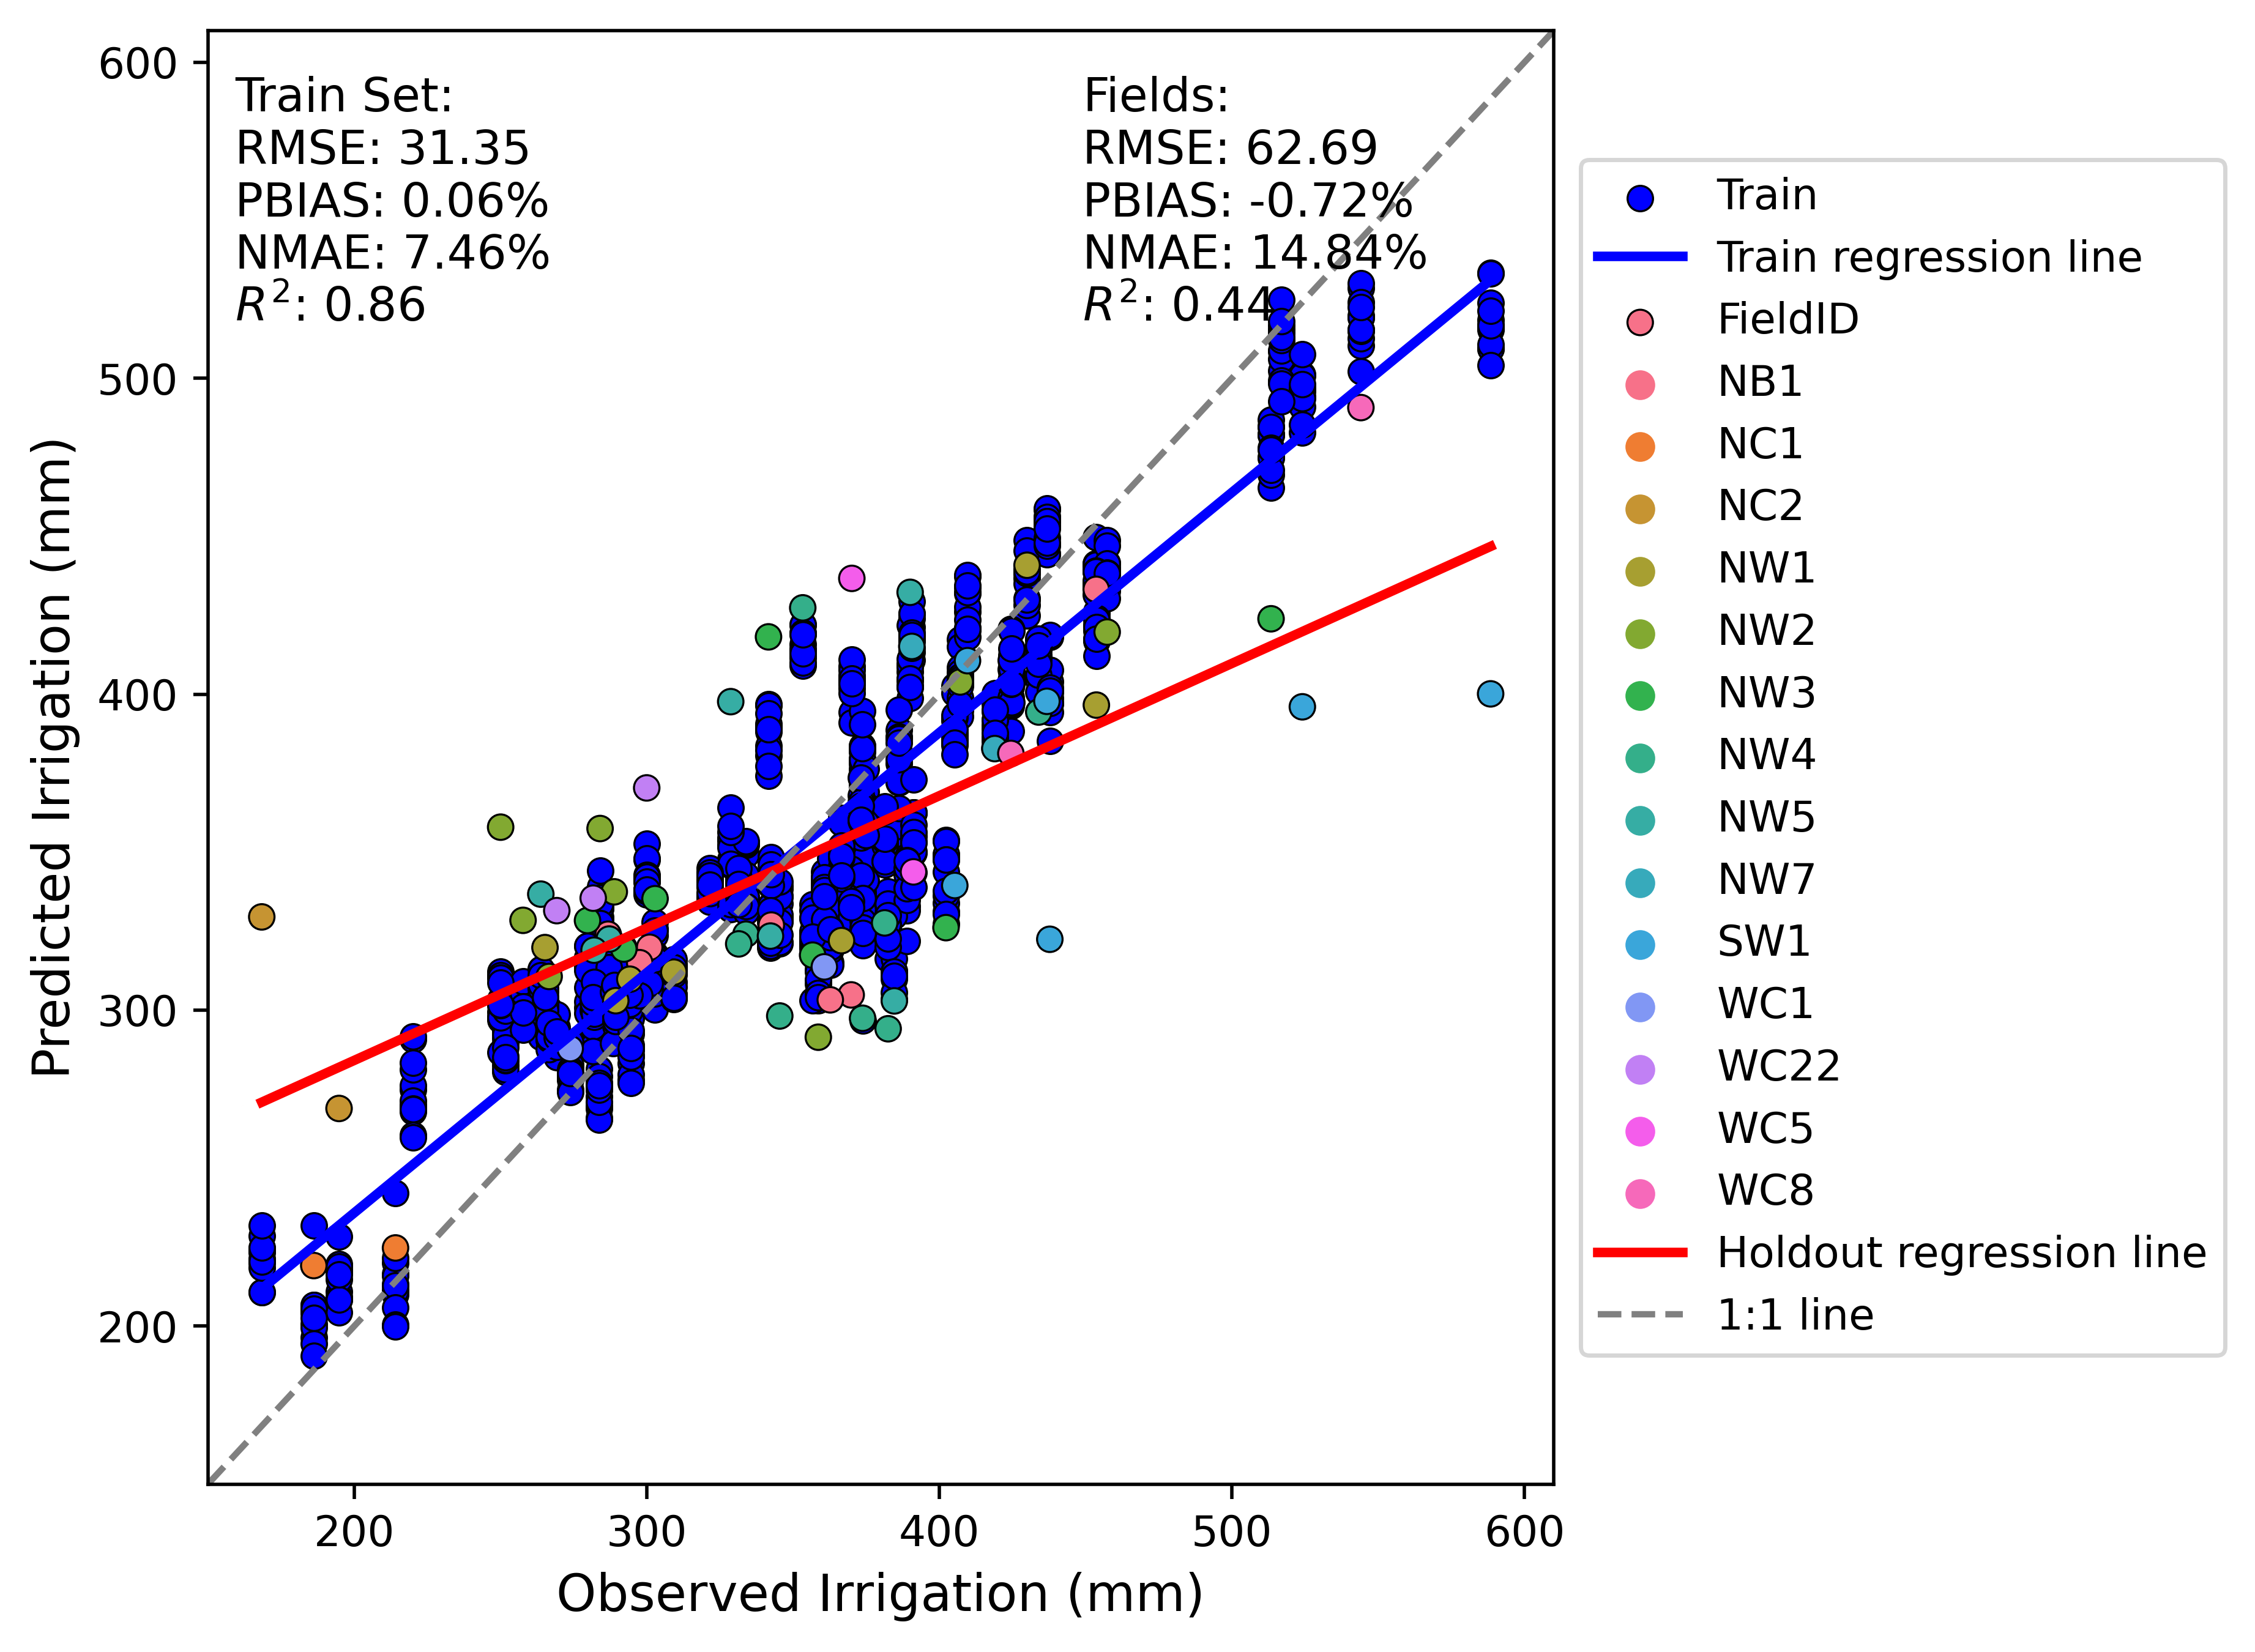

In [58]:
evaluate_model(
    y_train=train_results["Actual"], y_pred_train=train_results["Predicted"],
    y_holdout = holdout_results["Actual"], y_pred_holdout = holdout_results["Predicted"],
    units='mm',text = "Fields",
    label = "FieldID",
    hue =holdout_results["FieldID"],
    xlabel = "Observed Irrigation", ylabel = "Predicted Irrigation",
    xlim = (150, 610), ylim = (150, 610),
    p=.65,
    legend_outside=True
)


## residuals of the holdout validation 

In [59]:
irr_hld_yr["Resid"] =  irr_hld_yr["Predicted"] - irr_hld_yr["Actual"]
irr_hld_fid["Resid"] =  irr_hld_fid["Predicted"] -irr_hld_fid["Actual"]
irr_hld_fid

,Actual,Predicted,FieldID,Resid
0,300.984585,319.894073,NB1,18.909488
1,297.575357,315.014130,NB1,17.438773
2,369.860074,304.824432,NB1,-65.035642
3,342.563728,326.919647,NB1,-15.644081
4,286.767030,324.031952,NB1,37.264922
...,...,...,...,...
60,281.686000,335.445007,WC22,53.759007
61,391.160000,343.757721,WC5,-47.402279
62,370.078000,436.637482,WC5,66.559482
63,424.434000,381.241364,WC8,-43.192636


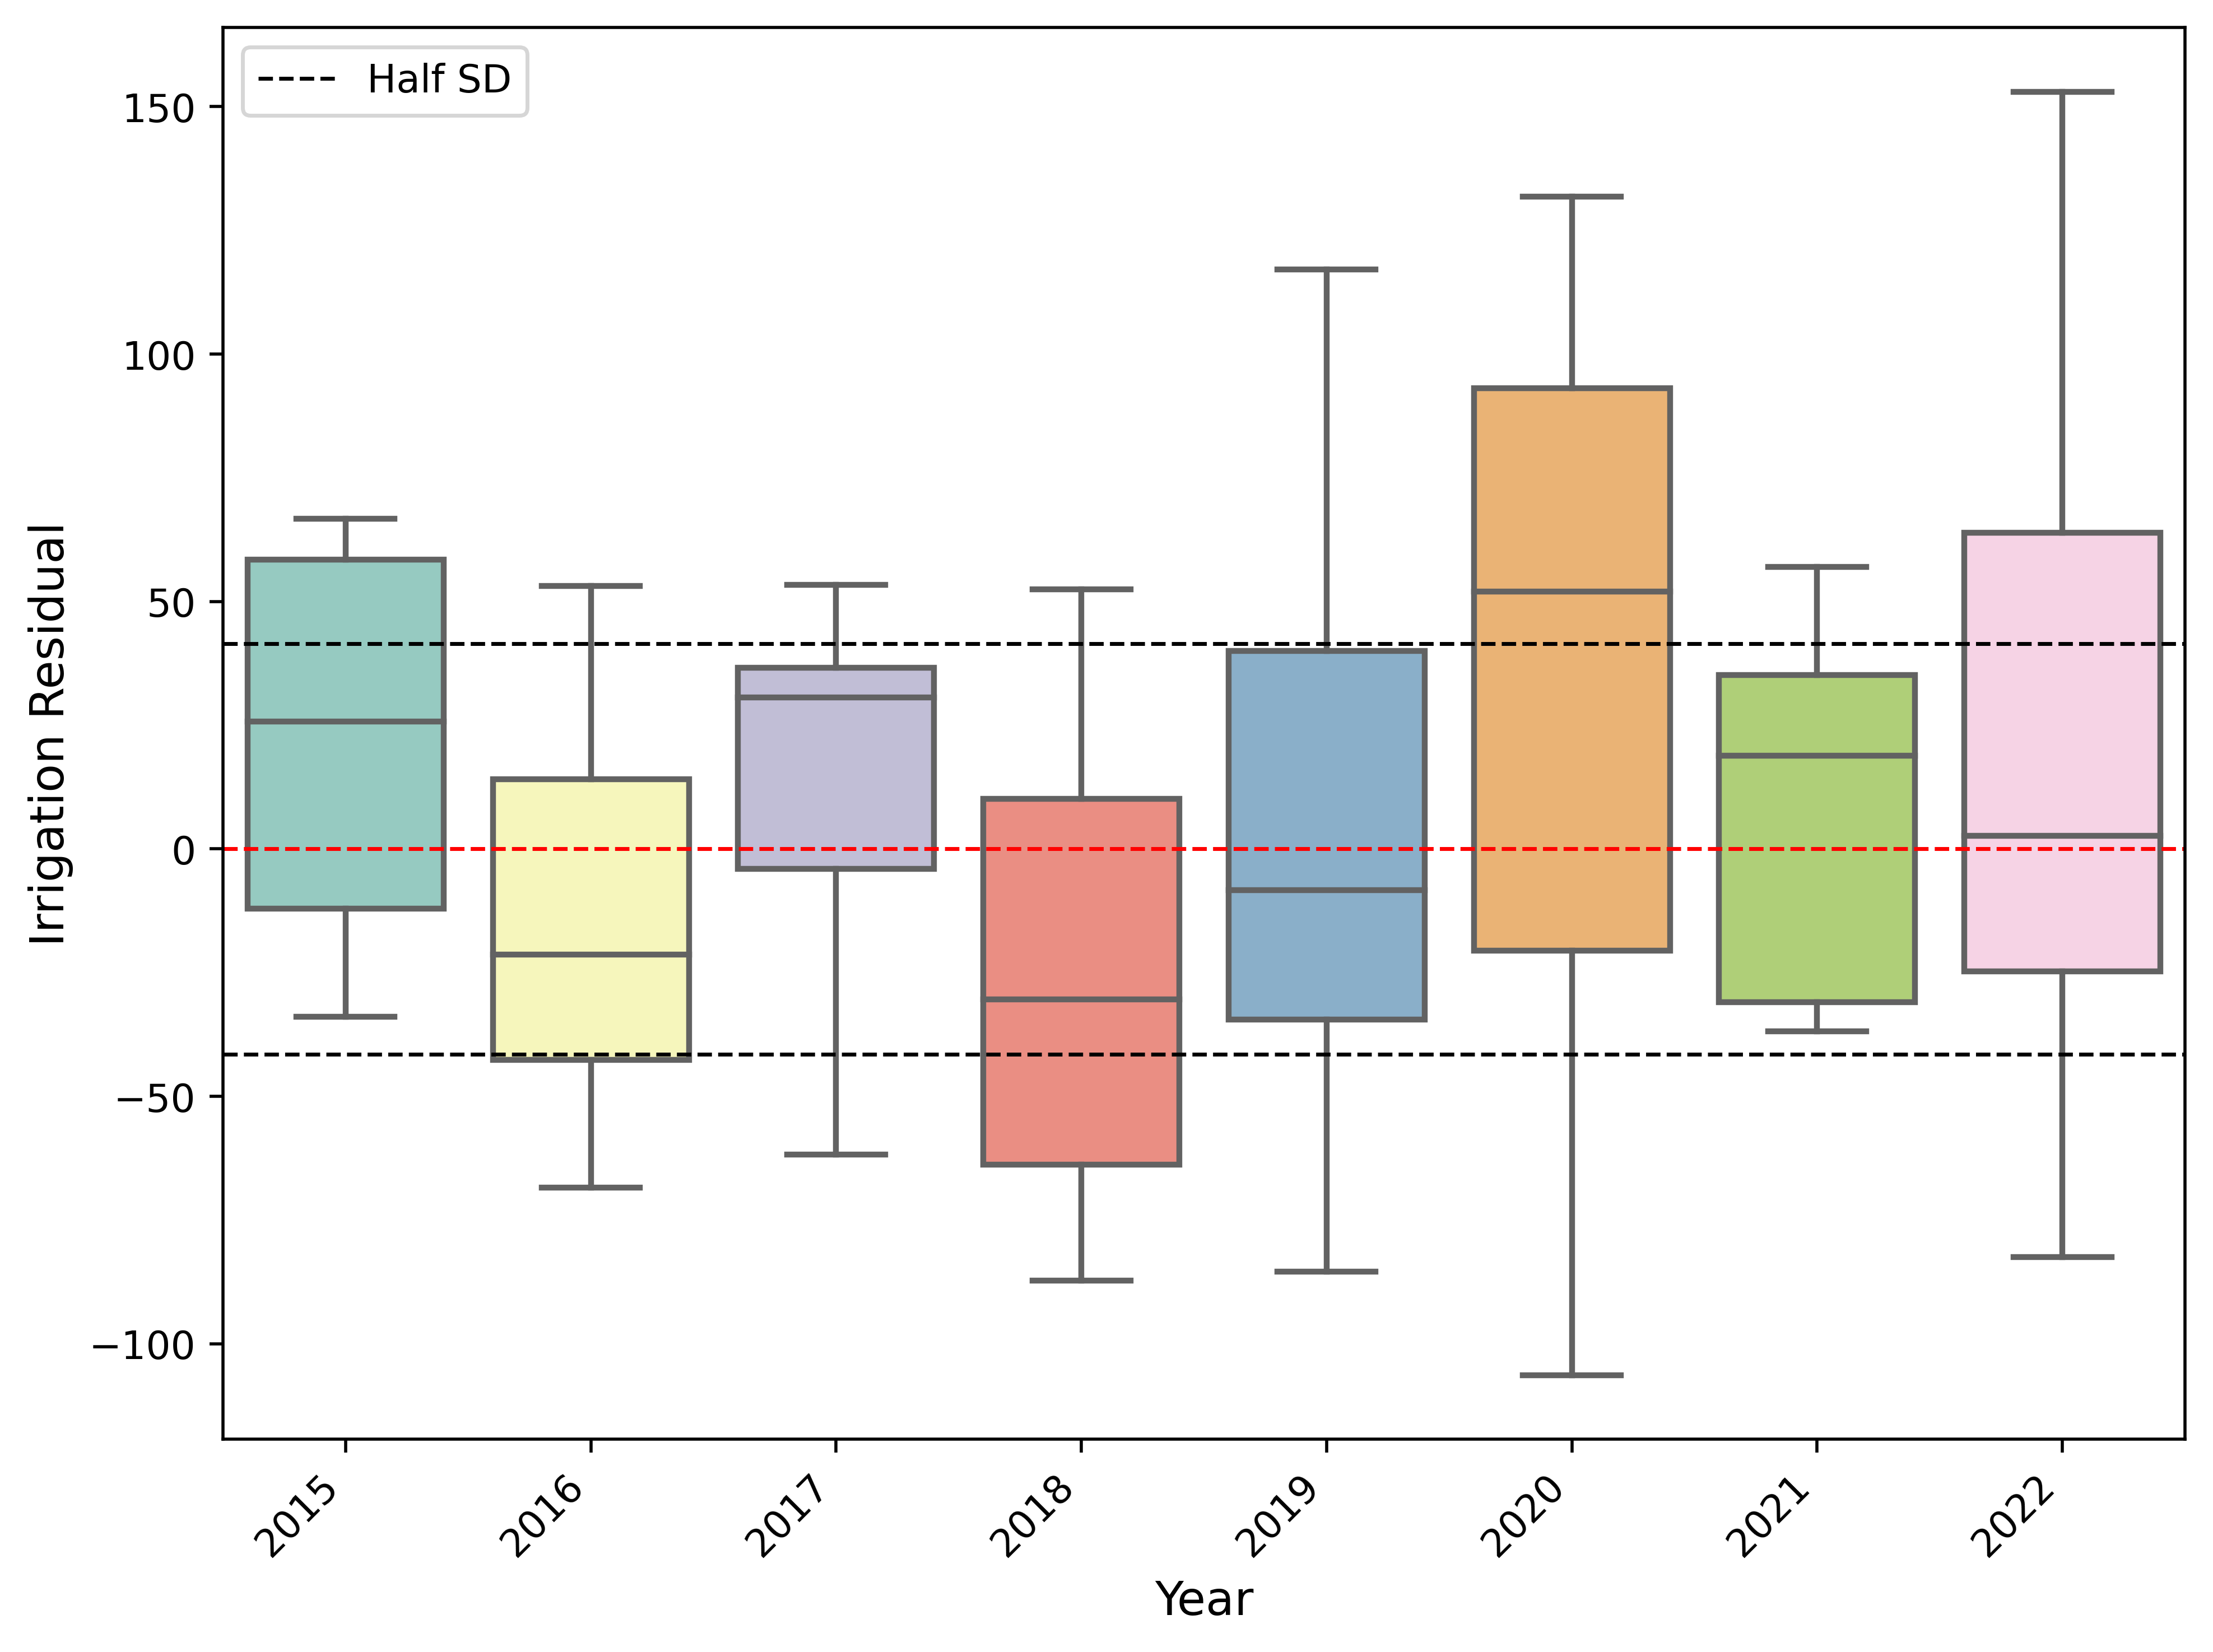

In [65]:
plot_residuals(irr_hld_yr, group_col="Year",xlabel = "Year", ylabel = "Irrigation Residual",
               add_half_std_lines =True, half_std_upper = 83/2 )

### Spatial and temporal Metric variation

In [38]:
# renaming to alighn with function requirements
irr_hld_yr = irr_hld_yr.rename(columns={"Actual": "Reported_Irrigation", "Predicted": "Predicted_Irrigation"})
irr_hld_fid = irr_hld_fid.rename(columns={"Actual": "Reported_Irrigation", "Predicted": "Predicted_Irrigation"})
irr_hld_fid 

,Reported_Irrigation,Predicted_Irrigation,FieldID
0,300.984585,319.894073,NB1
1,297.575357,315.014130,NB1
2,369.860074,304.824432,NB1
3,342.563728,326.919647,NB1
4,286.767030,324.031952,NB1
...,...,...,...
60,281.686000,335.445007,WC22
61,391.160000,343.757721,WC5
62,370.078000,436.637482,WC5
63,424.434000,381.241364,WC8


In [39]:
hld_yr_irri = calculate_yearly_metrics(
    df=irr_hld_yr,
    group_by_field=False,
    calculate_yield=False,
    calculate_irrigation=True,
    model="XGBoost Leave-One-Year-Out",
    estimated ="Predicted"
)

hld_yr_irri

,Year,Model,Metric,Irrigation
0,2015,XGBoost Leave-One-Year-Out,RMSE,44.575652
1,2015,XGBoost Leave-One-Year-Out,PBIAS,6.895861
2,2015,XGBoost Leave-One-Year-Out,NMAE,12.559934
3,2016,XGBoost Leave-One-Year-Out,RMSE,40.824457
4,2016,XGBoost Leave-One-Year-Out,PBIAS,-4.011487
5,2016,XGBoost Leave-One-Year-Out,NMAE,10.487611
6,2017,XGBoost Leave-One-Year-Out,RMSE,41.224500
7,2017,XGBoost Leave-One-Year-Out,PBIAS,3.948788
8,2017,XGBoost Leave-One-Year-Out,NMAE,12.421457
9,2018,XGBoost Leave-One-Year-Out,RMSE,52.404255


In [40]:
hld_fid_irri = calculate_yearly_metrics(
    df=irr_hld_fid,
    group_by_field=True,
    calculate_yield=False,
    calculate_irrigation=True,
    model="XGBoost Leave-One-Field-Out",
    estimated ="Predicted"
)

hld_fid_irri

,FieldID,Model,Metric,Irrigation
0,NB1,XGBoost Leave-One-Field-Out,RMSE,38.687553
1,NB1,XGBoost Leave-One-Field-Out,PBIAS,-3.602186
2,NB1,XGBoost Leave-One-Field-Out,NMAE,9.700841
3,NC1,XGBoost Leave-One-Field-Out,RMSE,24.501904
4,NC1,XGBoost Leave-One-Field-Out,PBIAS,10.893150
5,NC1,XGBoost Leave-One-Field-Out,NMAE,10.893150
6,NC2,XGBoost Leave-One-Field-Out,RMSE,125.381307
7,NC2,XGBoost Leave-One-Field-Out,PBIAS,64.746174
8,NC2,XGBoost Leave-One-Field-Out,NMAE,64.746174
9,NW1,XGBoost Leave-One-Field-Out,RMSE,35.416539


In [ ]:
# hld_yr_irri.to_csv("Data/irig_yr.csv")
# hld_fid_irri.to_csv("Data/irig_fid.csv")

In [45]:
# cv5 part

# renaming to alighn with function requirements

cv5results  = cv5results .rename(columns={"Actual": "Reported_Yield", "Predicted": "Predicted_Yield"})
cv5results 

,Fold,Set,Reported_Yield,Predicted_Yield,FieldID,Year
0,1,Train,300.984585,303.104248,NB1,2016
1,1,Train,297.575357,298.761658,NB1,2017
2,1,Train,369.860074,349.747955,NB1,2018
3,1,Train,342.563728,326.676422,NB1,2020
4,1,Train,453.614809,447.995636,NB1,2022
...,...,...,...,...,...,...
385,5,Test,373.126000,389.763367,WC21,2016
386,5,Test,220.218000,350.436798,WC23,2019
387,5,Test,544.068000,502.924988,WC8,2020
388,5,Test,388.874000,333.410675,WC9,2019


In [47]:
# tempral metrics
cv5_yr = calculate_yearly_metrics(
    df=cv5results,
    group_by_field=False,
    calculate_yield=True,
    calculate_irrigation=False,
    model="XGBoost Leave-One-Year-Out",
    estimated ="Predicted"
)
cv5_yr.head(2)

,Year,Model,Metric,Yield
0,2015,XGBoost Leave-One-Year-Out,RMSE,25.396056
1,2015,XGBoost Leave-One-Year-Out,PBIAS,1.403689


In [48]:
# spatial metrics

cv5_fid = calculate_yearly_metrics(
    df=cv5results,
    group_by_field=True,
    calculate_yield=True,
    calculate_irrigation=False,
    model="XGBoost Leave-One-Field-Out",
    estimated ="Predicted"
)

cv5_fid.head(2)

,FieldID,Model,Metric,Yield
0,NB1,XGBoost Leave-One-Field-Out,RMSE,22.146657
1,NB1,XGBoost Leave-One-Field-Out,PBIAS,-1.457001


In [49]:
# cv5_yr.to_csv("Data/cv5yr_irrig.csv")
# cv5_fid.to_csv("Data/cv5fid_irrig.csv")

### feature importance

In [50]:
selected_features = ['GDD', "NDVI", 'Precip_sum',
                     'ReferenceET_sum', 'Percent_Slope', 'Precip_deficit', "vpd"]
X_full = irrig_df[selected_features]
y_full = irrig_df["Reported_Irrigation"]

# 2. Best hyperparameters from previous tuning
best_params_irrig = {
    'colsample_bytree': 0.9,
    'subsample': 0.7,
    'learning_rate': 0.1,
    'max_depth': 2,
    'n_estimators': 50,
    'reg_alpha': 0.6,
    'gamma': 0.4
}

# 3. Train final model on full data
final_irrig_model = xgb.XGBRegressor(**best_params_irrig)
final_irrig_model.fit(X_full, y_full)

# 4. Predict and evaluate on training data (optional)
y_full_pred = final_irrig_model.predict(X_full)

mae_full = mean_absolute_error(y_full, y_full_pred)
rmse_full = np.sqrt(mean_squared_error(y_full, y_full_pred))
r2_full = r2_score(y_full, y_full_pred)

print(f"\n--- Full Data Performance ---")
print(f"MAE: {mae_full:.4f}, RMSE: {rmse_full:.4f}, R²: {r2_full:.4f}")



--- Full Data Performance ---
MAE: 27.0351, RMSE: 32.0867, R²: 0.8486


In [53]:
# Dictionary mapping original column names to short SHAP plot-friendly names
rename_dict = {
    'GDD': 'GDD',
    "vpd": "Mean VPD",
    'NDVI': 'Mean NDVI',
    'Precip_sum': 'Total Precip',
    'ReferenceET_sum': 'ET₀',
    'Percent_Slope': 'Slope (%)',
    'Precip_deficit': 'Precip Deficit'
}

# Rename the DataFrame columns
xfull_renamed = X_full.rename(columns=rename_dict)
xfull_renamed

,GDD,Mean NDVI,Total Precip,ET₀,Slope (%),Precip Deficit,Mean VPD
0,1644.890021,0.651859,544.150002,1139.259996,5.472,132.020586,1.781269
1,1614.254973,0.660628,535.800001,1148.359997,5.472,112.251549,1.951652
2,1644.100009,0.714815,443.960002,1130.510002,5.472,252.480036,1.620673
3,1624.754994,0.587987,331.310000,1218.569996,5.472,325.580253,1.925848
4,1718.870071,0.660427,438.000001,1166.679999,5.472,192.049207,1.791752
...,...,...,...,...,...,...,...
73,1700.526132,0.724703,489.789186,1165.082234,4.102,237.066737,1.646104
74,1701.755233,0.822295,487.784813,1164.180538,3.796,320.343176,1.646104
75,1700.526132,0.702208,489.789186,1165.082234,3.941,257.455799,1.652755
76,1700.526132,0.652330,489.789186,1165.082234,4.025,202.070211,1.652755


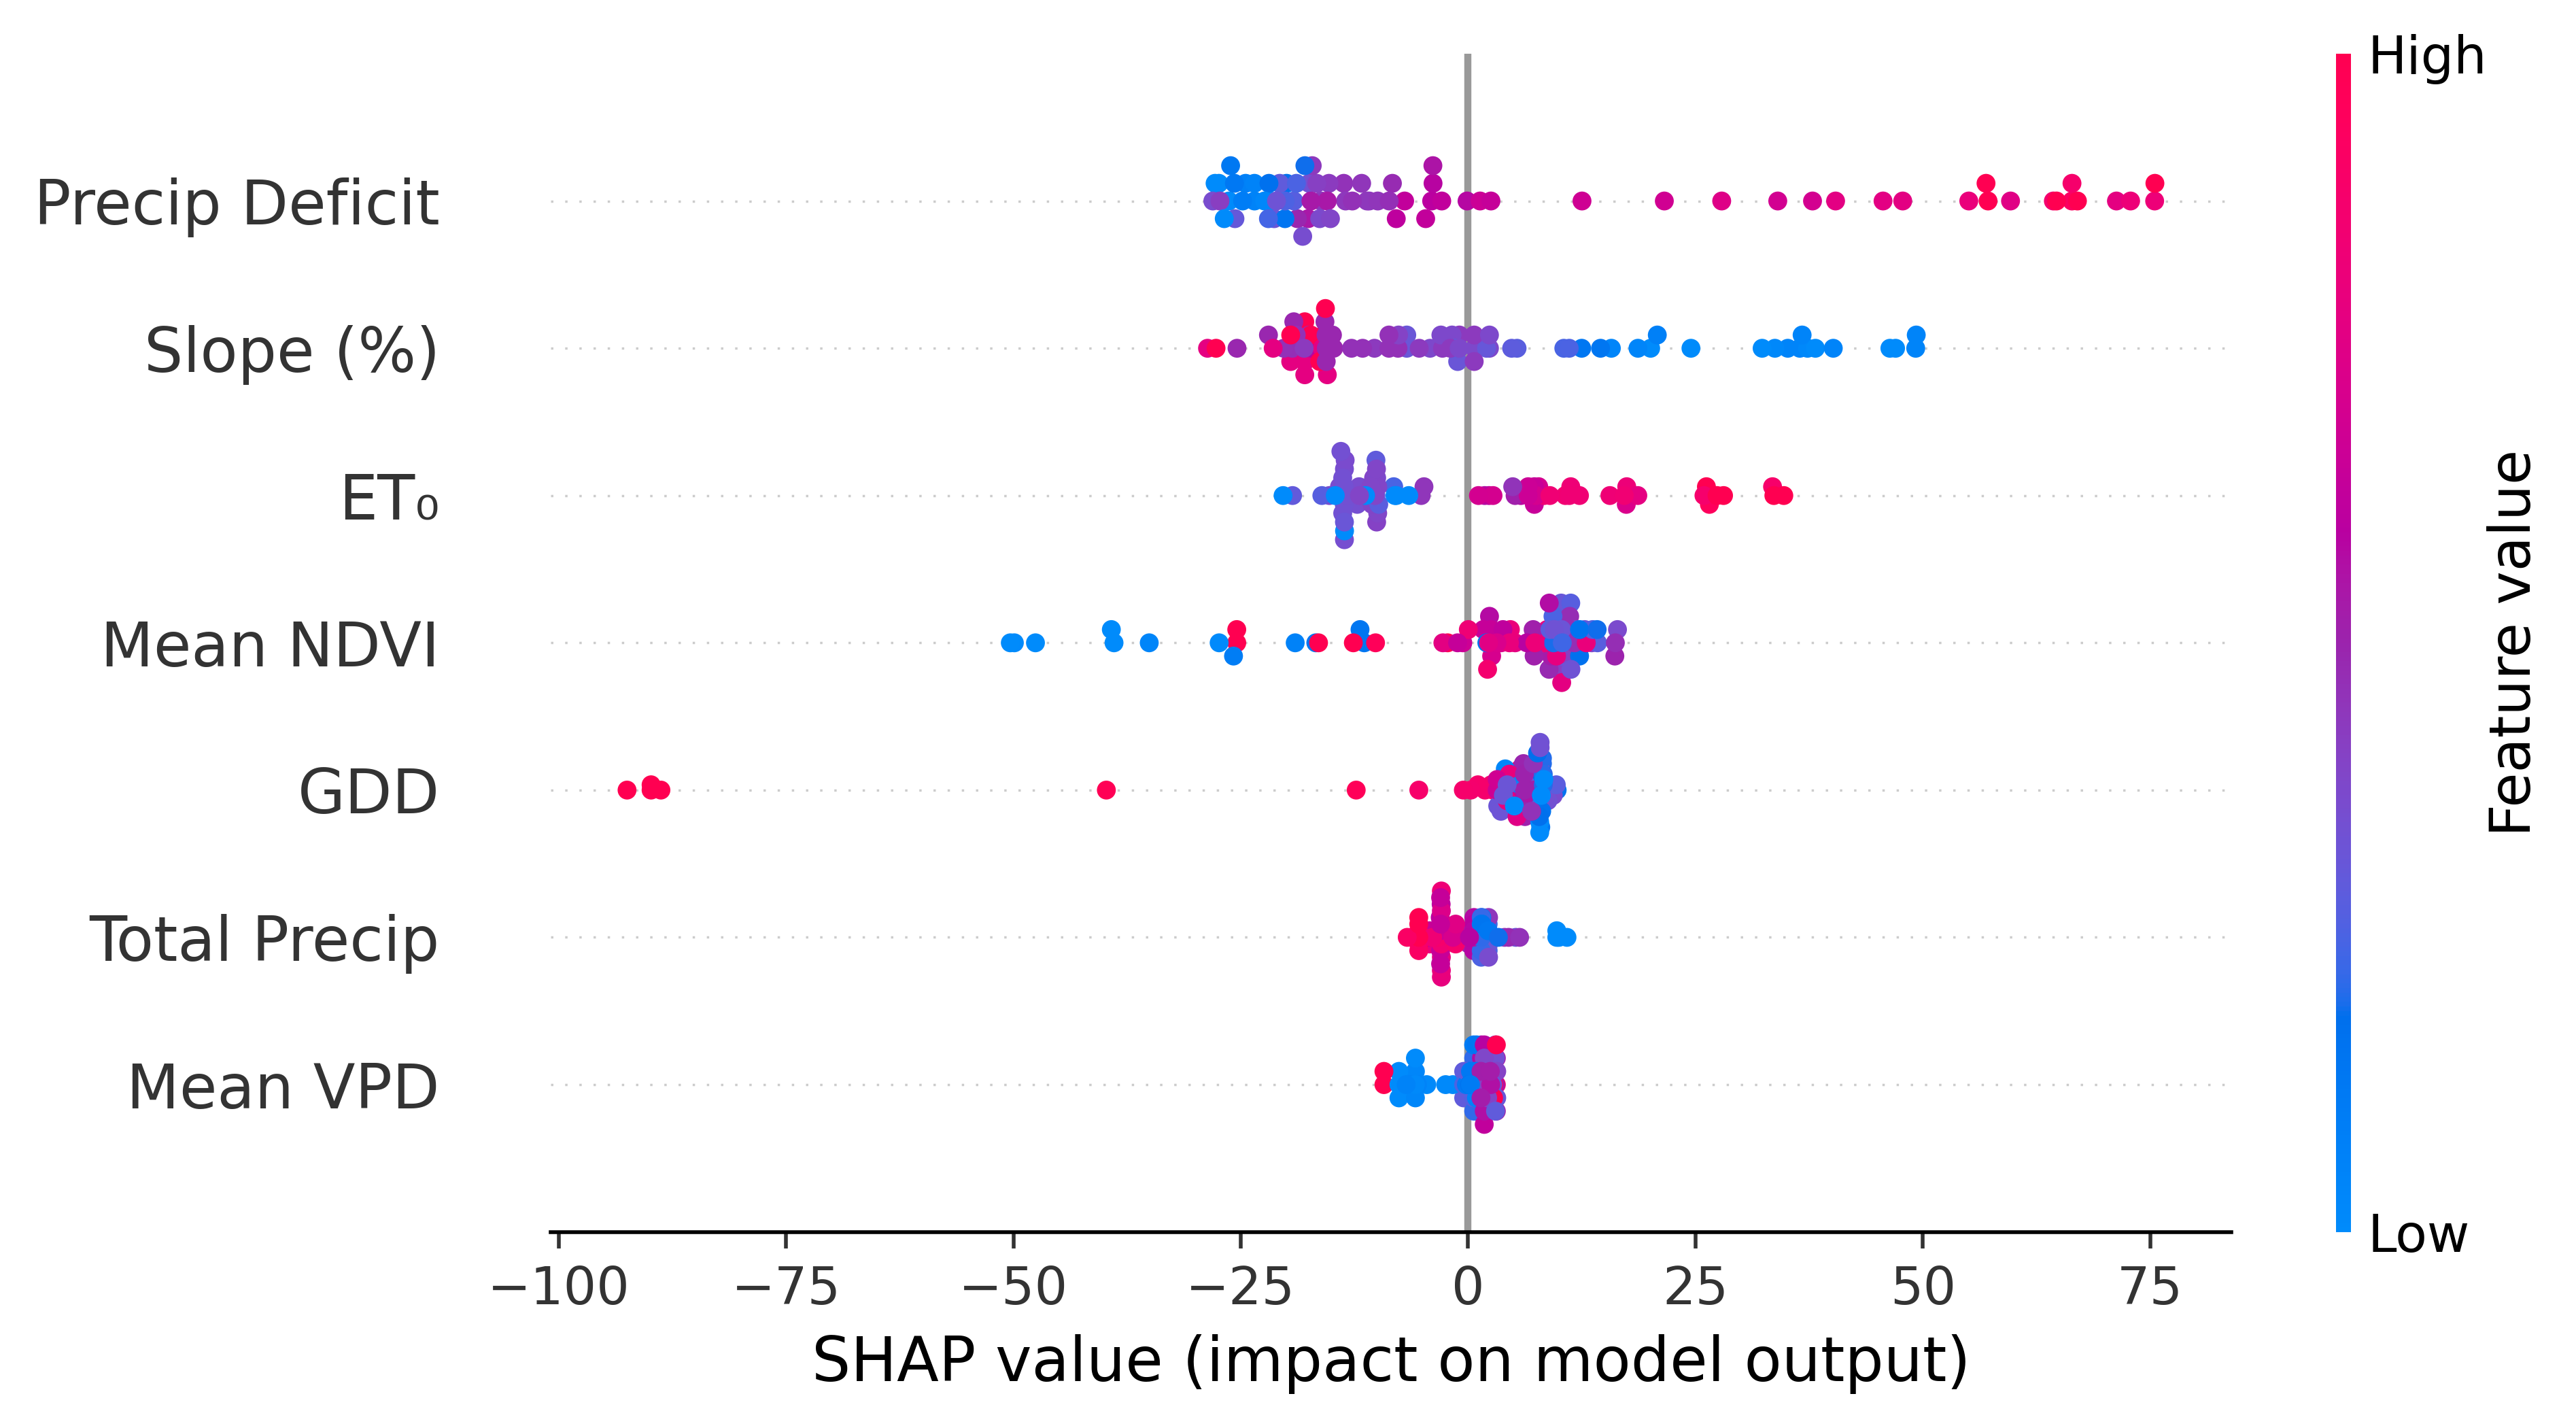

In [54]:
X_importance =  xfull_renamed

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(final_irrig_model)
shap_values = explainer.shap_values(X_importance)

# Plot top 15 features
shap.summary_plot(shap_values, X_importance, max_display=10)